In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("SalesForecasting_aerry").getOrCreate()

In [3]:
df = spark.read.csv("sales_data_1500.csv", header=True, inferSchema=True)
df.show(5)

+----------+--------+----+----+-----+---------+-----------+------------------+
|Product_ID|Store_ID|Week|Year|Price|Promotion|Sales_Units|     Sales_Revenue|
+----------+--------+----+----+-----+---------+-----------+------------------+
|      P004|    S002|  25|2023|37.56|        0|         29|           1089.24|
|      P005|    S003|  40|2024|17.78|        1|         24|            426.72|
|      P003|    S001|  24|2023|13.97|        0|         28|            391.16|
|      P005|    S002|  14|2023|83.99|        0|         24|2015.7599999999998|
|      P005|    S001|  26|2023|92.25|        0|         19|           1752.75|
+----------+--------+----+----+-----+---------+-----------+------------------+
only showing top 5 rows


In [4]:
df = df.withColumn("Promotion", when(col("Promotion") == 1, 1).otherwise(0))

In [5]:
product_indexer = StringIndexer(inputCol="Product_ID", outputCol="Product_Idx")
store_indexer = StringIndexer(inputCol="Store_ID", outputCol="Store_Idx")

df = product_indexer.fit(df).transform(df)
df = store_indexer.fit(df).transform(df)

In [6]:
assembler = VectorAssembler(
    inputCols=["Product_Idx", "Store_Idx", "Week", "Year", "Price", "Promotion"],
    outputCol="features"
)

data = assembler.transform(df)
final_data = data.select("features", "Sales_Revenue")

In [7]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [8]:
lr = LinearRegression(labelCol="Sales_Revenue")
lr_model = lr.fit(train_data)

In [9]:
predictions = lr_model.transform(test_data)
predictions.select("Sales_Revenue", "prediction").show(5)

+-------------+------------------+
|Sales_Revenue|        prediction|
+-------------+------------------+
|       702.36| 845.9179753359131|
|       580.26| 644.3331752530466|
|      1235.75|1010.0165796314541|
|      1431.76|1309.2323446631926|
|      1179.42|1106.3608997150986|
+-------------+------------------+
only showing top 5 rows


In [10]:
evaluator = RegressionEvaluator(labelCol="Sales_Revenue", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 239.18816770153896


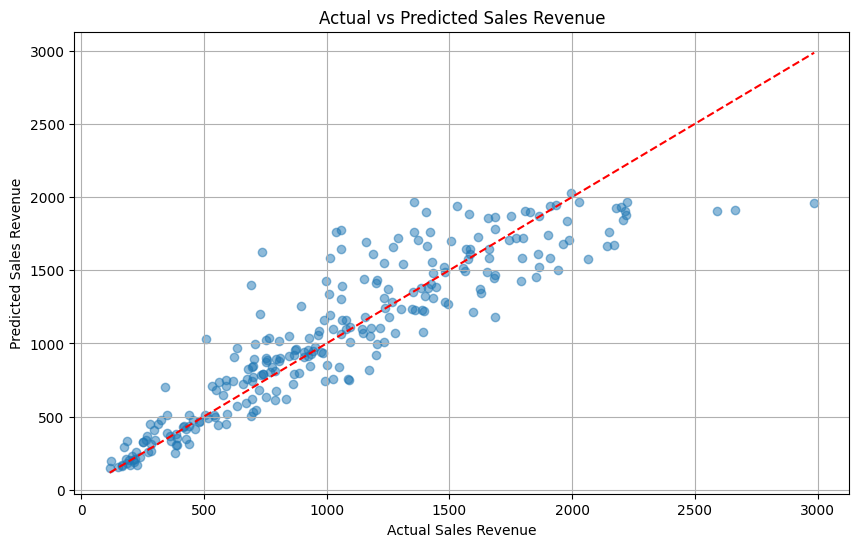

In [11]:
pandas_df = predictions.select("Sales_Revenue", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["Sales_Revenue"], pandas_df["prediction"], alpha=0.5)
plt.plot(
    [pandas_df["Sales_Revenue"].min(), pandas_df["Sales_Revenue"].max()],
    [pandas_df["Sales_Revenue"].min(), pandas_df["Sales_Revenue"].max()],
    color='red', linestyle='--'
)
plt.xlabel("Actual Sales Revenue")
plt.ylabel("Predicted Sales Revenue")
plt.title("Actual vs Predicted Sales Revenue")
plt.grid(True)
plt.show()